In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from scipy.stats import mannwhitneyu

In [6]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [7]:
from scipy.stats import spearmanr
from natsort import natsorted

In [8]:
save_images = False

In [9]:
outfolder = '200515_transcript_length_tilting_with_confidence'

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']
].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [12]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes)) & 
    (all_de['padj'].notnull()) &
    (all_de['younger']==4)
]


In [13]:
conditions = natsorted(all_de['condition'].unique())

In [14]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [15]:
for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p

In [16]:
out = out.reset_index()

In [17]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [18]:
# add addtional labels
helper = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [19]:
df_between_ages = helper[['tissue', 'older', 'corr']].copy()
df_between_ages.loc[:, 'origin'] = 'data'

In [20]:
p = inout.get_internal_path(
    'datasets/tstoeger/200129_pool_inner_bootstraps/age_groups.csv.gz')

In [21]:
df_b = pd.read_csv(p)
tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

In [22]:
df_b = df_b[
    df_b['tissue'].isin(tissues_to_consider)
].copy()

In [23]:
df_b = df_b.dropna(subset=['gene_ncbi', 'padj'])   # now indlude analogosus filtering

In [24]:
master_b = pd.merge(df_b, pr)

In [25]:
grouped = master_b.groupby(['tissue', 'age', 'animals'])

In [26]:
agg = []
for name, group in grouped:
    tissue, age, animals = name
    rho, pval = spearmanr(group['length'], group['o_over_y'])
    
    res = dict()
    res['tissue'] = tissue
    res['age'] = age
    res['rho'] = rho
    res['pval'] = pval
    res['animals'] = animals
    
    agg.append(res)

In [27]:
mega = pd.DataFrame(agg)

In [28]:
helper = mega.groupby(['tissue', 'age']).agg(np.median).reset_index()

In [29]:
df_combos = helper[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

In [30]:
df_combos.loc[:, 'origin'] = 'median'

In [31]:
df_combos.head()

,tissue,older,corr,origin
0,Adrenal,4,6.405164e-03,median
1,Adrenal,9,1.553793e-05,median
2,Adrenal,12,-4.141488e-06,median
3,Adrenal,18,1.426022e-03,median
4,Adrenal,24,2.115428e-08,median


In [32]:
df_variations = mega[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

df_variations.loc[:, 'origin'] = 'variations'

In [33]:
master = pd.concat([
    df_between_ages,
    df_variations,
    df_combos
])

In [34]:
master['short_label'] = master['origin'] + '_' + master['older'].astype(int).astype(str)
master['corr'] = master['corr'].astype(float)

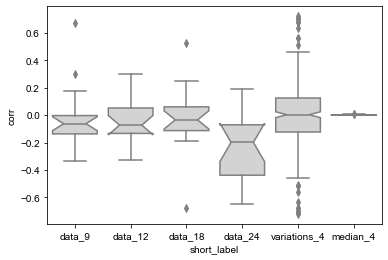

In [35]:
sns.boxplot(
    x='short_label', 
    y='corr', 
    data=master, 
    notch=True, 
    order=['data_9', 'data_12', 'data_18', 'data_24', 'variations_4','median_4'],
    color='lightgrey')

if save_images:
    export.export_image('{}/box_legacy.pdf'.format(outfolder))



In [36]:
master

,tissue,older,corr,origin,short_label
0,Adrenal,9.0,-3.628703e-03,data,data_9
1,Adrenal,12.0,-8.325523e-02,data,data_12
2,Adrenal,18.0,6.005663e-02,data,data_18
3,Adrenal,24.0,-1.620019e-01,data,data_24
4,BAT,9.0,-1.538250e-02,data,data_9
...,...,...,...,...,...
79,WAT,4.0,2.118254e-03,median,median_4
80,WAT,9.0,2.040713e-02,median,median_9
81,WAT,12.0,-5.006383e-07,median,median_12
82,WAT,18.0,-1.249419e-06,median,median_18


In [37]:
master[master['corr'].notnull()]['short_label'].value_counts()

variations_4     330
variations_24    320
variations_12    302
variations_9     300
variations_18    290
data_18           17
data_24           17
median_4          17
data_9            17
median_12         17
median_24         17
median_9          17
data_12           17
median_18         16
Name: short_label, dtype: int64

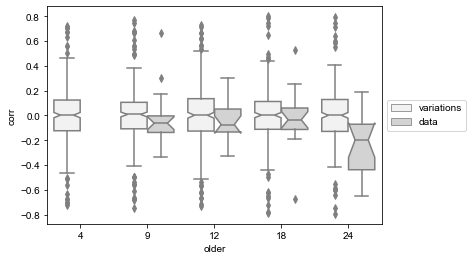

In [38]:
sns.boxplot(
    x='older', 
    y='corr', 
    data=master[master['origin'].isin(['variations', 'data'])], 
    notch=True, 
    hue='origin',
    order=[4, 9, 12, 18, 24],
    color='lightgrey',
    hue_order=['variations', 'data']
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


if save_images:
    export.export_image('{}/hue_box.pdf'.format(outfolder))



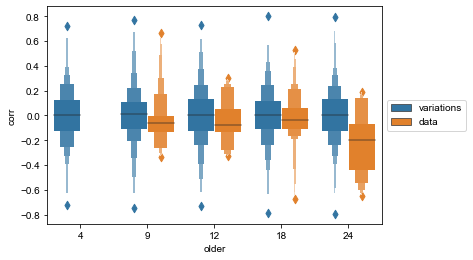

In [39]:
sns.boxenplot(
    x='older', 
    y='corr', 
    data=master[master['origin'].isin(['variations', 'data'])], 
    hue='origin',
    order=[4, 9, 12, 18, 24],
    hue_order=['variations', 'data']
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if save_images:
    export.export_image('{}/hue_boxen.pdf'.format(outfolder))



In [40]:
toy = pd.DataFrame(data={'pos': np.arange(1, 101)})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


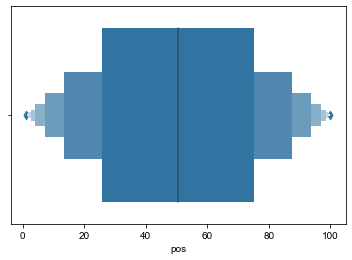

In [41]:
sns.boxenplot(toy['pos'])

if save_images:
    export.export_image('{}/plain_boxen.pdf'.format(outfolder))



In [42]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            master[(master['origin']=='variations') & (master['older']==4)]['corr'],
            master[(master['origin']=='data') & (master['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=3250.0, pvalue=0.2704509256605967)
12 MannwhitneyuResult(statistic=3168.0, pvalue=0.3687983209411986)
18 MannwhitneyuResult(statistic=2935.0, pvalue=0.7481631645687467)
24 MannwhitneyuResult(statistic=4171.0, pvalue=0.0007107200703220447)


In [43]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            master[(master['origin']=='variations') & (master['older']==j)]['corr'],
            master[(master['origin']=='data') & (master['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=3002.0, pvalue=0.21939245054194623)
12 MannwhitneyuResult(statistic=2872.0, pvalue=0.41053475814391815)
18 MannwhitneyuResult(statistic=2606.0, pvalue=0.6928623304903523)
24 MannwhitneyuResult(statistic=4058.0, pvalue=0.0006334889237962325)


In [44]:
mannwhitneyu(
    master[(master['origin']=='data') & (master['older']==9)]['corr'],
    master[(master['origin']=='data') & (master['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=207.0, pvalue=0.03272027315980588)

In [45]:
mannwhitneyu(
    master[(master['origin']=='data') & (master['older']==9)]['corr'],
    master[(master['origin']=='data') & (master['older']==12)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=143.0, pvalue=0.9725234705442696)

In [46]:
master[
    (master['origin']=='variations') &
    (master['older']==24)
]['tissue'].value_counts()

Adrenal       20
GutEP         20
MuscSat       20
Kidney        20
Esophagus     20
LI            20
Blood         20
BAT           20
Skin          20
Stomach       20
Heart         20
WAT           20
Lung          20
Brain         20
Liver         20
SI            10
Cerebellum    10
Name: tissue, dtype: int64